In [795]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score

from sklearn.pipeline import make_pipeline

from sklearn.inspection import plot_partial_dependence

from category_encoders import OrdinalEncoder

from waterfall_chart import plot as water_fall

from treeinterpreter import treeinterpreter

from fastbook import *

import warnings
warnings.filterwarnings(action = "ignore")

### Load dataset and perform cleaning/EDA

In [42]:
#Load data set
df = pd.read_csv("Dataset/data_clean")
df.head()

,LoanStatus,TotalProsperLoans,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPrincipalBorrowed,ProsperPaymentsOneMonthPlusLate,BorrowerAPR,ListingCategory (numeric),BorrowerState,EmploymentStatus,...,StatedMonthlyIncome,IncomeVerifiable,LoanOriginalAmount,MonthlyLoanPayment,ScorexChangeAtTimeOfListing,Term,ListingCreationDate,ProsperRating,Listing_Year,RevolveRatio
0,Completed,0,-1,-1,0.0,-1,0.16516,0,CO,Self-employed,...,3083.333333,True,9425,330.43,NaN,36,2007-08-26,C,2007,0.007784
1,Current,0,-1,-1,0.0,-1,0.12016,2,CO,Employed,...,6125.000000,True,10000,318.93,NaN,36,2014-02-27,A,2014,0.063510
2,Completed,0,-1,-1,0.0,-1,0.28269,0,GA,Not available,...,2083.333333,True,3001,123.32,NaN,36,2007-01-05,HR,2007,0.000000
3,Current,0,-1,-1,0.0,-1,0.12528,16,GA,Employed,...,2875.000000,True,10000,321.45,NaN,36,2012-10-22,A,2012,0.040000
4,Current,1,11,0,11000.0,0,0.24614,2,MN,Employed,...,9583.333333,True,15000,563.97,NaN,36,2013-09-14,D,2013,0.022957


In [43]:
#Check information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113932 entries, 0 to 113931
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   LoanStatus                           113932 non-null  object 
 1   TotalProsperLoans                    113932 non-null  int64  
 2   OnTimeProsperPayments                113932 non-null  int64  
 3   ProsperPaymentsLessThanOneMonthLate  113932 non-null  int64  
 4   ProsperPrincipalBorrowed             113932 non-null  float64
 5   ProsperPaymentsOneMonthPlusLate      113932 non-null  int64  
 6   BorrowerAPR                          113932 non-null  float64
 7   ListingCategory (numeric)            113932 non-null  int64  
 8   BorrowerState                        108420 non-null  object 
 9   EmploymentStatus                     113932 non-null  object 
 10  CurrentlyInGroup                     113932 non-null  bool   
 11  FirstRecorded

In [44]:
#Drop the column borrower state

df.drop(columns = "BorrowerState", inplace = True)

In [45]:
#Drop the column PublicRecordsLast12Months

df.drop(columns = "PublicRecordsLast12Months", inplace = True)

In [46]:
#Drop the column ScorexChangeAtTimeOfListing

df.drop(columns = "ScorexChangeAtTimeOfListing", inplace = True)

In [47]:
#Drop rows tha do not have entries of First RecordedLine

df = df[~df["FirstRecordedCreditLine"].isnull()]

In [48]:
#Feature engineer the column FirstRecordedCreditLine to firstrecordedcredityear

df["firstrecordedcredityear"] = pd.to_datetime(df["FirstRecordedCreditLine"]).dt.year

In [49]:
#Drop FirstRecordedCreditLine 

df.drop(columns = "FirstRecordedCreditLine", inplace=True)

In [50]:
#Drop na

df.dropna(inplace=True)

In [51]:
df.isnull().sum().sum()

0

In [52]:
#Replace revolve ratio infinity values with 50,000 (A value not as high the previous values in dataset)
df["RevolveRatio"].sort_values(ascending=False)[1267:1290]

15739              inf
25457              inf
69954              inf
83949              inf
72461              inf
57893              inf
39687              inf
105702             inf
35151              inf
66819              inf
28721     4.682419e+04
109119    3.855615e+04
8461      3.806415e+04
226       3.439214e+04
82318     3.319213e+04
103546    2.754011e+04
103606    2.640011e+04
67695     2.636411e+04
109041    2.618410e+04
60563     2.600410e+04
55168     2.583610e+04
81982     2.328009e+04
19884     2.149209e+04
Name: RevolveRatio, dtype: float64

In [53]:
#Replace
df["RevolveRatio"] = df["RevolveRatio"].replace(np.inf, 50_000)

In [54]:
#Check new values
df["RevolveRatio"].sort_values(ascending=False)[1267:1290]

15739     50000.000000
25457     50000.000000
69954     50000.000000
83949     50000.000000
72461     50000.000000
57893     50000.000000
39687     50000.000000
105702    50000.000000
35151     50000.000000
66819     50000.000000
28721     46824.187297
109119    38556.154225
8461      38064.152257
226       34392.137569
82318     33192.132769
103546    27540.110160
103606    26400.105600
67695     26364.105456
109041    26184.104736
60563     26004.104016
55168     25836.103344
81982     23280.093120
19884     21492.085968
Name: RevolveRatio, dtype: float64

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112577 entries, 0 to 113931
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   LoanStatus                           112577 non-null  object 
 1   TotalProsperLoans                    112577 non-null  int64  
 2   OnTimeProsperPayments                112577 non-null  int64  
 3   ProsperPaymentsLessThanOneMonthLate  112577 non-null  int64  
 4   ProsperPrincipalBorrowed             112577 non-null  float64
 5   ProsperPaymentsOneMonthPlusLate      112577 non-null  int64  
 6   BorrowerAPR                          112577 non-null  float64
 7   ListingCategory (numeric)            112577 non-null  int64  
 8   EmploymentStatus                     112577 non-null  object 
 9   CurrentlyInGroup                     112577 non-null  bool   
 10  OpenCreditLines                      112577 non-null  int64  
 11  OpenRevolving

### Split the dataset
- What we want to do is to split our dataset and use that algorithm to predict foe those still currently paying whether they will default or not.

In [56]:
#DRop those who are currently paying

data = df[df["LoanStatus"] != "Current"]

In [57]:
#Create column defaulted, where 1 represents yes and 0 represents 0 and completed

#Create function for that

def is_defaulted(x):
    if x == "Completed":
        return 0
    else:
        return 1

In [58]:
data["defaulted"] = data["LoanStatus"].apply(is_defaulted)

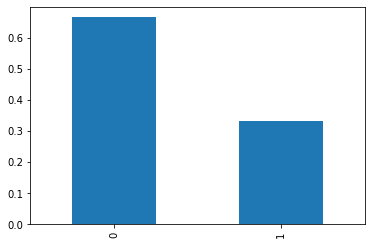

In [59]:
#Class balance
data["defaulted"].value_counts(normalize = True).plot(kind = "bar");

In [60]:
#Drop LoanStatus columns

data.drop(columns = "LoanStatus", inplace = True)

In [61]:
#Split dataset into training and testing

target = "defaulted"
X = data.drop(columns = target)
y = data[target]

In [705]:
#Convert prosper rating to ordered categorical type
df["ProsperRating"]=pd.Categorical(df["ProsperRating"], categories =['A', 'AA', 'B', 'C', 'D', 'E', 'HR', 'NC'], ordered=True)

In [706]:
df["ProsperRating"].dtype

CategoricalDtype(categories=['A', 'AA', 'B', 'C', 'D', 'E', 'HR', 'NC'], ordered=True)

In [707]:
#Split into train and test dataset

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 42, test_size = 0.2
)

### Set baseline for model

In [63]:
y_train.value_counts(normalize = True).max()

0.6668906810035843

### Begin Model Iteration

#### Random Forest Classifier

In [715]:
rf_clf = make_pipeline(OrdinalEncoder(mapping=[{"col": "ProsperRating", "mapping": {"NC":0, "AA":1,
                                                            "A":2, "B":3, "C":4,
                                                           "D":5, "E":6, "HR":7}}]),
                            OrdinalEncoder(),
                    RandomForestClassifier(oob_score = True))

In [716]:
param_rf = {
    "randomforestclassifier__n_estimators": range(50, 401, 50),
    "randomforestclassifier__max_samples": np.arange(0.25, 1.0, 0.25),
    "randomforestclassifier__max_depth": [5, 10, 15],
    "randomforestclassifier__max_features": ["sqrt", "log2"]
}
param_rf

{'randomforestclassifier__n_estimators': range(50, 401, 50),
 'randomforestclassifier__max_samples': array([0.25, 0.5 , 0.75]),
 'randomforestclassifier__max_depth': [5, 10, 15],
 'randomforestclassifier__max_features': ['sqrt', 'log2']}

In [421]:
#create model

rf_model = RandomizedSearchCV(rf_clf, 
                   param_distributions=param_rf,
                   cv = 5, n_jobs=-1,
                   n_iter=200, verbose=1,
                   random_state=42
                  )
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(oob_score=True))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              15],
                                        'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log2'],
                                        'randomforestclassifier__max_samples': array([0.25, 0.5 , 0.75]),
                                        'randomforestclassifier__n_estimators': range(50, 401, 50)},
                   random_state=42, verbose=1)

In [423]:
rf_model.best_params_

{'randomforestclassifier__n_estimators': 400,
 'randomforestclassifier__max_samples': 0.5,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__max_depth': 15}

In [442]:
#Check accuracy of model
print(f"The random forest model best score is given as {round(rf_model.best_score_, 2)}")

The random forest model best score is given as 0.72


In [544]:
#Accuracy score of the model on X_test
accuracy_score(y_test, rf_model.predict(X_test))

0.6984411395807203

From the above we see that the model is doing well not to overfit and at the same time acheives a model accuracy of 72%. We will henceforth go to model explicability of the result that we obtained.

### Random Forest Results Explained.

In [425]:
#Extract out the RF model from the pipeline
rf_m = rf_model.best_estimator_.named_steps["randomforestclassifier"]
rf_m

RandomForestClassifier(max_depth=15, max_features='log2', max_samples=0.5,
                       n_estimators=400, oob_score=True)

#### Effect of the addition of trees to model mean squared error and accuracy.

In [605]:
#Define function mean abbsolute error

def mse(true, pred):
    return ((true - pred)**2).mean()

def mae(true, pred):
    return (abs(true - pred)).mean()

In [743]:
#transform test set
cat_encoder = make_pipeline(OrdinalEncoder(mapping=[{"col": "ProsperRating", "mapping": {"NC":0, "AA":1,
                                                            "A":2, "B":3, "C":4,
                                                           "D":5, "E":6, "HR":7}}]),
                            OrdinalEncoder()
                           )
X_test_t=cat_encoder.fit_transform(X_test)
X_test_t.head(2)

,TotalProsperLoans,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPrincipalBorrowed,ProsperPaymentsOneMonthPlusLate,BorrowerAPR,ListingCategory (numeric),EmploymentStatus,CurrentlyInGroup,OpenCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,AmountDelinquent,CurrentDelinquencies,DelinquenciesLast7Years,PublicRecordsLast10Years,DebtToIncomeRatio,IncomeRange,StatedMonthlyIncome,IncomeVerifiable,LoanOriginalAmount,MonthlyLoanPayment,Term,ListingCreationDate,ProsperRating,Listing_Year,RevolveRatio,firstrecordedcredityear
17480,0,-1,-1,0.0,-1,0.07607,1,1,False,2,3,10.0,0.0,4.0,0.0,0.0,0.0,0.0,0.02,1,2166.666667,True,1000,30.38,36,1,1,1,0.004615,1
7123,0,-1,-1,0.0,-1,0.32297,2,1,False,7,6,189.0,1.0,5.0,0.0,0.0,2.0,1.0,0.60,2,1066.666667,True,2500,106.02,36,2,5,2,0.177187,2


In [523]:
test_preds = np.stack([m.predict(X_test_t) for m in rf_m.estimators_])
test_preds.shape

(400, 5581)

In [672]:
#Mimimicking the accuracy score of the model on X_test by taking the mean predictions of each treest
#And checking accuracy compared to the y_tes
accuracy_score(y_test, (test_preds.mean(0)>0.49))

0.6950367317685002

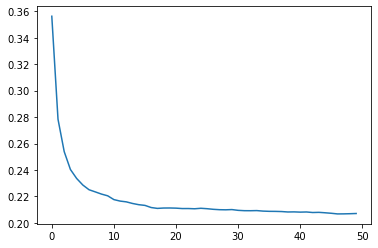

In [633]:
#Plot the graph of decreasing mean suared error as we add more trees
plt.plot([mse(y_test, test_preds[:i+1].mean(0)) for i in range(50)]);

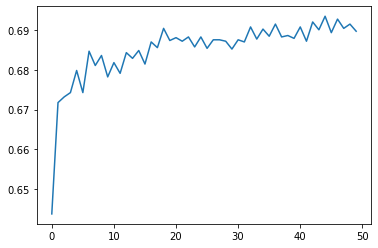

In [632]:
#Plot the graph of increasing accuracy score as we add more trees
plt.plot([accuracy_score(y_test, (test_preds[:i+1].mean(0)>0.5)) for i in range(50)]);

#### RF model's variance

By checking the Random Forest model variance we can see how each trees agree on a particular decision to be made. A high Standard deviation shows disparity and dispute among the trees that make up the forest and can be used in production to examine the precision of the forest.

In [636]:
#Check for model sd
preds.std(0)

array([0.30474101, 0.23115474, 0.26748221, ..., 0.22000224, 0.22686603,
       0.25042336])

#### Feature Importance

Feature Importance in decision trees and consequently random forests is obtained by considering the number of times that a particular feature was used in making a binary splits and the weighted loss improvement that resulted as a result of the split that was made. We are going to make a plot that will show the feature importance.

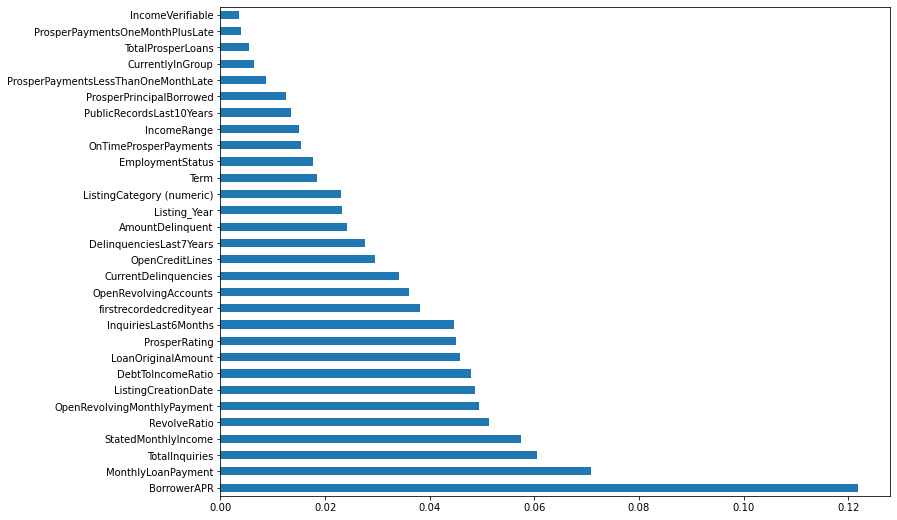

In [647]:
fi = pd.Series(rf_m.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fi.plot(kind="barh", figsize=[12, 9]);

From the above plot, we can see that the BorrowerAPR has the highest feature importance and whether an income is  verifiable or not does not really play a role in the tree splitting. We will be dropping these and see the effect on dropping them on the accuracy score.

In [719]:
#Drop columns with feature importance less than 0.04

X_fi = X_train[fi[fi>0.04].index]
X_fi

,BorrowerAPR,MonthlyLoanPayment,TotalInquiries,StatedMonthlyIncome,RevolveRatio,OpenRevolvingMonthlyPayment,ListingCreationDate,DebtToIncomeRatio,LoanOriginalAmount,ProsperRating,InquiriesLast6Months
66124,0.30564,125.72,21.0,4333.333333,0.016615,72.0,2007-09-18,0.13,3000,E,1.0
1999,0.23250,101.72,9.0,5416.666667,0.031938,173.0,2008-04-22,0.16,2700,HR,2.0
100741,0.27119,292.87,1.0,4916.666667,0.063051,310.0,2010-08-17,-10.00,7500,C,0.0
7562,0.14558,450.26,29.0,11250.000000,0.014400,162.0,2007-04-06,0.10,16000,C,10.0
102885,0.09186,94.70,5.0,20833.333333,0.000480,10.0,2006-07-23,0.15,3000,AA,1.0
...,...,...,...,...,...,...,...,...,...,...,...
91455,0.35643,174.20,6.0,2632.083333,0.020516,54.0,2011-10-26,0.09,4000,HR,4.0
110968,0.32368,127.34,19.0,7083.333333,0.004941,35.0,2008-09-12,0.02,3000,E,3.0
77806,0.11184,162.49,4.0,3416.666667,0.000000,0.0,2007-04-03,0.13,5000,B,2.0
1861,0.07872,61.77,13.0,7000.000000,0.067571,473.0,2008-04-12,0.13,2000,AA,0.0


In [764]:
#Define function that trains model with just a dataframe entry using the default hyperparameters that we obtained

def rf_modelling(x, y, n_estimators=400, max_samples=0.5,
                max_features='log2', max_depth=15):
    if "ProsperRating" in x.columns:
        pipeline = make_pipeline(OrdinalEncoder(mapping=[{"col": "ProsperRating", "mapping": {"NC":0, "AA":1,
                                                                "A":2, "B":3, "C":4,
                                                               "D":5, "E":6, "HR":7}}]),
                                OrdinalEncoder(),
                                 RandomForestClassifier(n_estimators=n_estimators,
                                                       max_samples=max_samples,
                                                       max_features=max_features,
                                                       max_depth=max_depth,
                                                       oob_score = True)).fit(x, y)
    else:
        pipeline = make_pipeline(OrdinalEncoder(),
                                 RandomForestClassifier(n_estimators=n_estimators,
                                                       max_samples=max_samples,
                                                       max_features=max_features,
                                                       max_depth=max_depth,
                                                       oob_score = True)).fit(x, y)
        
    return pipeline

In [739]:
m_fi = rf_modelling(X_fi, y_train)
m_fi

Pipeline(steps=[('ordinalencoder-1',
                 OrdinalEncoder(cols=['ListingCreationDate', 'ProsperRating'],
                                mapping=[{'col': 'ProsperRating',
                                          'mapping': {'A': 2, 'AA': 1, 'B': 3,
                                                      'C': 4, 'D': 5, 'E': 6,
                                                      'HR': 7, 'NC': 0}}])),
                ('ordinalencoder-2',
                 OrdinalEncoder(cols=['ListingCreationDate'],
                                mapping=[{'col': 'ListingCreationDate',
                                          'data_type': dtype('O'),
                                          'mapping': 2007-09-18       1
2008-04-22       2
2010-08-17       3
2007-04-06       4
2006-07-23       5
              ... 
2009-05-06    2528
2014-01-04    2529
2014-02-04    2530
2013-11-28    2531
NaN             -2
Length: 2532, dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, max_features='log2',
                                        max_samples=0.5, n_estimators=400,
                                        oob_score=True))])

In [741]:
#Check oob_score
m_fi.named_steps["randomforestclassifier"].oob_score_

0.7059363799283154

In [744]:
#Extract model from the pipeline
rfm_fi = m_fi.named_steps["randomforestclassifier"]

#Convert X_test_t to access only feature importannt variables

X_test_fi = X_test_t[fi[fi>0.04].index]

#Check accuracy score on the X_test
accuracy_score(y_test, rfm_fi.predict(X_test_fi))

0.7109577994803333

When we observe the accuracy, we see that the accuracy has slightly increased. And we now have lesser columns to deal with.

In [675]:
#Define function that returns the plot of feature importance given the model and the dataset

def plot_fi(rf_model, x, figsize):
    series = pd.Series(rf_model.feature_importances_, index=x.columns).sort_values(ascending=False)
    return series.plot(kind="barh", figsize=figsize)

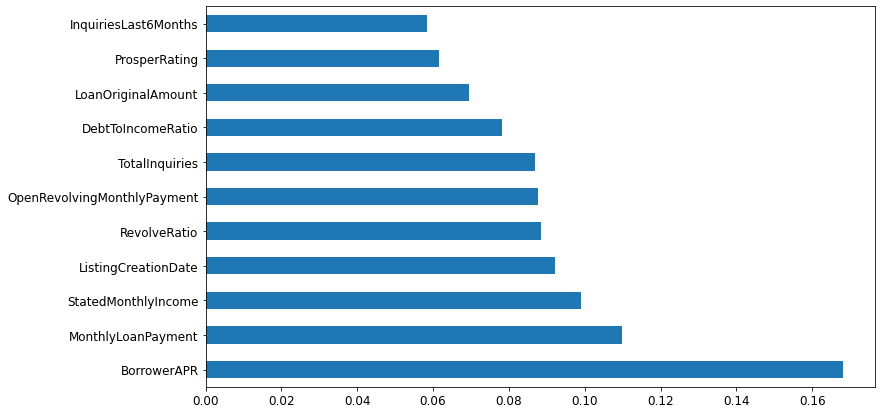

In [745]:
plot_fi(rfm_fi, X_fi, figsize=[12,7]);

Use the fastbook `cluster columns` to draw a tree that shows how related (using a pearson correlation coefficient unerhood) different columns of a dataset are.

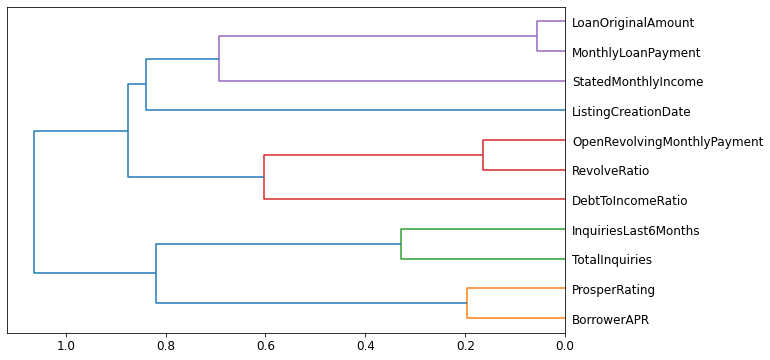

In [746]:
cluster_columns(X_fi)

In [757]:
#Create a list of tightly coupled data

corr_features = ["LoanOriginalAmount", "MonthlyLoanPayment", "OpenRevolvingMonthlyPayment", "RevolveRatio",
"InquiriesLast6Months", "TotalInquiries", "BorrowerAPR", "ProsperRating"]

In [748]:
#Let us drop each feature, train each dataframe result and check the effect on the oob_score of the model

def get_oob(df):
    p = rf_modelling(df, y_train, n_estimators=400, max_samples=0.25, max_depth=10)
    return p.named_steps["randomforestclassifier"].oob_score_

In [749]:
#Print baseline for X_fi

get_oob(X_fi)

0.7040546594982079

In [766]:
#Use dictionary comprehension to see the effect of each column on the oob_score_

{c:get_oob(X_fi.drop(columns=c)) for c in corr_features}

{'LoanOriginalAmount': 0.7029345878136201,
 'MonthlyLoanPayment': 0.7011872759856631,
 'OpenRevolvingMonthlyPayment': 0.7049731182795699,
 'RevolveRatio': 0.7055107526881721,
 'InquiriesLast6Months': 0.703584229390681,
 'TotalInquiries': 0.7027329749103942,
 'BorrowerAPR': 0.702844982078853,
 'ProsperRating': 0.7022625448028674}

From the above output, we see that most of the columns do not really result in a low oob_score_. We can remove one feature from each pair of features, columns that if removed, they will result in a better oob_score.

In [769]:
to_drop = ["LoanOriginalAmount", "OpenRevolvingMonthlyPayment", "InquiriesLast6Months"]
#I left both borowerAPR and ProsperRating because of their high contributions

In [771]:
#Define function that takes extracts onl rf model

def extract_rf(model):
    return model.named_steps["randomforestclassifier"]

In [772]:
#Now let us drop these columns and retrain the model and check the accuracy

X_drop = X_fi.drop(columns=to_drop)
X_test_drop = X_test_fi.drop(columns=to_drop)

#Retrain model
model_drop = rf_modelling(X_drop, y_train)

#Check accuracy
accuracy_score(y_test, extract_rf(model_drop).predict(X_test_drop))

0.7097034315921512

In [861]:
#Print oobscore
extract_rf(model_drop).oob_score_

0.7029793906810036

From this, we observe that we have removed so many redundant columns and even in some cases improved the model and most especially the explicability of a model.

#### Partial Dependence

Partial dependence refers to how the prediction of a model depends on a particular feature alone. This means that how will the model vary if only a feature is varied and all other features are kept constant. We will be using sklearn inspection tool for this.

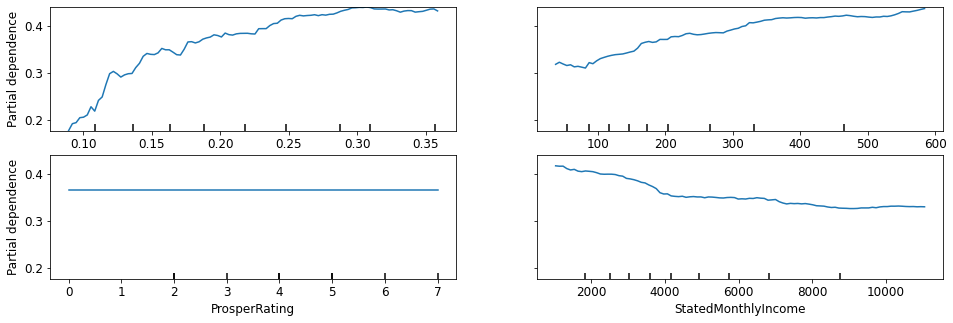

In [784]:
#plt.figure(figsize=[12,7])
fig, ax = plt.subplots(2, 2, figsize=[16, 5])

plot_partial_dependence(model_drop, X_test_drop, ["BorrowerAPR", "MonthlyLoanPayment",
                                                  "ProsperRating", "StatedMonthlyIncome"], ax=ax);

From the plots of the partial dependence of the three features(that we chose from) above, we do observe the following:
- There is a general increase in the partial dependence or the possibility of a person to default a Loan as the BorrowerAPR increases or MonthlyLoanPayment increases which actually makes sense.
- However, we see that the possibility of a person defaulting a loan does not seem to depend on varying the ProsperRating, or rather that the model could not pick it up.
- Also, as the StatedMonthlyIncome increases, so does the possibility (partial dependence) of defaulting a loan decreases but sort of wears out (reduces) and flattens out at around 4000.


#### Using tree interpreter and waterfall charts to explain a given prediction.

We will be making use of the tree interpreter library to generate the prediction, bias and contributions of a given test value.

In [785]:
rf_model_drop = extract_rf(model_drop)

In [787]:
rows = X_test_drop.iloc[:100]
rows.head(3)

,BorrowerAPR,MonthlyLoanPayment,TotalInquiries,StatedMonthlyIncome,RevolveRatio,ListingCreationDate,DebtToIncomeRatio,ProsperRating
17480,0.07607,30.38,4.0,2166.666667,0.004615,1,0.02,1
7123,0.32297,106.02,5.0,1066.666667,0.177187,2,0.60,5
2076,0.35643,174.20,2.0,8333.333333,0.465360,3,0.69,6


In [831]:
prediction,bias,contributions = treeinterpreter.predict(rf_model_drop, rows.values)

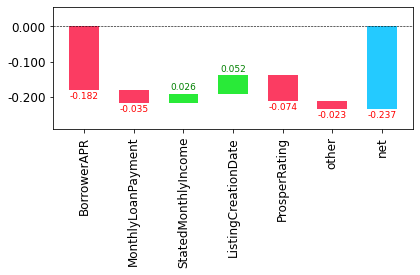

In [816]:
waterfall(X_test_drop.columns, contributions[0][:,1], threshold=0.08, 
          rotation_value=90,formatting='{:,.3f}');

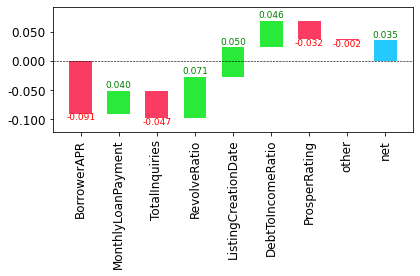

In [818]:
waterfall(X_test_drop.columns, contributions[3][:,1], threshold=0.08, 
          rotation_value=90,formatting='{:,.3f}');

The waterfall plots above show how individual features contribute to the preiction that was made by the random forest model.

#### Random Forest Extrapolation Problem.

Random Forest is known to not be able to extrapolate well with attributes of a feature it has not seen before. In order to mitigate against this in the valid dataset and in future datasets. It is important to first to have designed a good validation set which should be a good representation of the test set that is being envisaged. Then to check which features of the dataset is likely to cause extrapolation issues from the validation set in comparism to the training set. This can be done with using random forest. Let us continue with this.

In [840]:
X_extrapolation = pd.concat([X_drop, X_test_drop])
is_test = np.array([0] *len(X_drop) + [1]*len(X_test_drop))

#Model the forest to get feature importance
extra_model = rf_modelling(X_extrapolation, is_test)

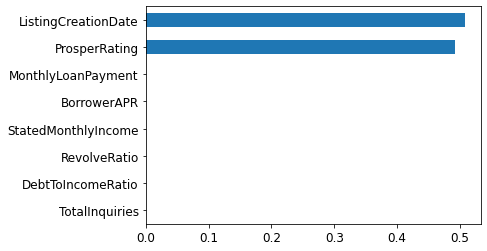

In [844]:
#Extract model
rf_extra = extract_rf(extra_model)

#
pd.Series(rf_extra.feature_importances_, X_extrapolation.columns).sort_values().plot(kind="barh");

In [850]:
accuracy_score(is_test, extra_model.predict(X_extrapolation))

1.0

In [851]:
extra_model.predict(X_extrapolation)

array([0, 0, 0, ..., 1, 1, 1])

Listing Creation Date and Prosper Rating seem to be two features that were use in the splitting to identy between which dataframe is a train set and which one is a test set

In [853]:
#Baseline oob score for the model drop

extract_rf(model_drop).oob_score_

0.7029793906810036

In [859]:
#Let us see the effect of dropping the columns on the oob score
X_drop_t = cat_encoder.transform(X_drop)
{c:get_oob(X_drop_t.drop(columns=c)) for c in ["ListingCreationDate", "ProsperRating"]}

{'ListingCreationDate': 0.7036514336917563,
 'ProsperRating': 0.7000224014336918}

Dropping ProsperRating reduces the oob_score compared to ListingCreationDate. Dropping the listing creation date seems to improve the oob score. We also do know that ListingCreation Date is going to be very different from each other, so it makes very much sense that they can cause extrapolation problem. I will thus drop Listing Creation Date and train the model on this as our final model.

In [863]:
X_final = X_drop.drop(columns="ListingCreationDate")
X_test_final = X_test_drop.drop(columns="ListingCreationDate")

In [864]:
#Train Model of X_final

model_final = rf_modelling(X_final, y_train)
model_final

Pipeline(steps=[('ordinalencoder-1',
                 OrdinalEncoder(cols=['ProsperRating'],
                                mapping=[{'col': 'ProsperRating',
                                          'mapping': {'A': 2, 'AA': 1, 'B': 3,
                                                      'C': 4, 'D': 5, 'E': 6,
                                                      'HR': 7, 'NC': 0}}])),
                ('ordinalencoder-2', OrdinalEncoder(cols=[], mapping=[])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, max_features='log2',
                                        max_samples=0.5, n_estimators=400,
                                        oob_score=True))])

In [866]:
#Check oob_score
extract_rf(model_final).oob_score_

0.7041666666666667

In [ ]:
rf_final = extract_rf(model_final)

In [871]:
accuracy_score(y_test, extract_rf(model_final).predict(X_test_final))
#accuracy_score(y_test, model_final.predict(X_test[X_test_final.columns]))

0.7098826270047487

This model looks nicer than at the very begining in which case we obtained an increase of close to 2% by adjusting our feature importance. However, I must note at this point an experimental design flop from my end in which case I used the test set as I would a validation set. The reason was mainly because of the resillience of random forest to overfitting which once I identified in the first test I did, I then went on to use it as a validation set. On the other end, on future iterations using other models, this same experimental flop might spill into their iterations.

**OOB SCORE** OOB Score also known as out of bag score refers to the model score (in the case of classification, the accuracy score) averaged over each each row. In practise what happens is that while a particular tree(in the forest) uses only a subsample of the whole dataset to train the tree. After training the tree, the model generated is then tested on the held out datasets that were not used in training. This serves as an internal validation sets for the trees. Such that eventually after training, there are multiple accuracy scores registered for each different rows which are averaged over the rows and over the columns and the score is obtained.

### Model Iteration continues...